In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import itertools

In [2]:
df = pd.read_csv('final_dataframe.csv',index_col=0)

# Baseline: Dummy Classifier

In [3]:
feats = ['series','rating','publish_month','publish_company','genre','top_authors']

X = pd.get_dummies(df[feats], drop_first=True)

Y = df['NYT_bestseller']

In [4]:
X.columns

Index(['series', 'rating', 'top_authors', 'publish_month_August',
       'publish_month_December', 'publish_month_February',
       'publish_month_January', 'publish_month_July', 'publish_month_June',
       'publish_month_March',
       ...
       'genre_short-stories', 'genre_spirituality', 'genre_sports-and-games',
       'genre_suspense', 'genre_thriller', 'genre_travel', 'genre_westerns',
       'genre_womens-fiction', 'genre_writing', 'genre_young-adult'],
      dtype='object', length=529)

In [5]:
X.drop([col for col, val in X.sum().iteritems() if val < 15], axis=1, inplace=True)

In [7]:
# normalize the features

for col in X.columns:
    X[col] = (X[col]-min(X[col]))/ (max(X[col]) - min(X[col])) 

#We subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature

X.head()

,series,rating,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,publish_month_June,publish_month_March,...,genre_mystery,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_thriller,genre_young-adult
0,0.0,0.624434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.597285,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.588235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.619910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.583710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [9]:
dum_clf = DummyClassifier(strategy='most_frequent')
dum_model = dum_clf.fit(X_train,y_train)
y_hat_train = dum_clf.predict(X_train)
y_hat_test = dum_model.predict(X_test)

In [10]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [11]:
print_metrics(y_hat_test,y_test)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.6848484848484848
F1 Score: 0.0


/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Confusion matrix, without normalization
[[226   0]
 [104   0]]


<Figure size 432x288 with 0 Axes>

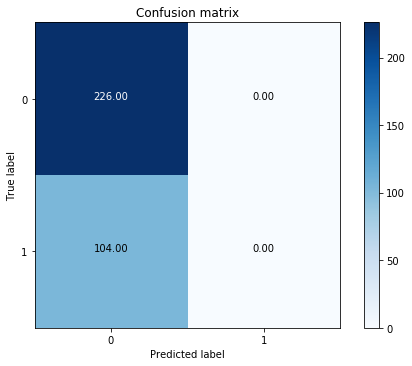

In [14]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)

plt.figure()
plt.figure(figsize=(7,5))

plot_confusion_matrix(cnf_matrix, classes=[0,1],normalize=False,
                      title='Confusion matrix')
plt.show()

# Final: Logistic Regression

In [15]:
logreg = LogisticRegression(solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
# y_hat predicted values
y_hat_test_log = logreg.predict(X_test)
y_hat_train_log = logreg.predict(X_train)

In [17]:
# metrics
print_metrics(y_hat_train_log, y_train)
print('----------')
print_metrics(y_hat_test_log,y_test)

Precision Score: 0.4004474272930649
Recall Score: 0.6654275092936803
Accuracy Score: 0.7279635258358662
F1 Score: 0.5
----------
Precision Score: 0.41346153846153844
Recall Score: 0.671875
Accuracy Score: 0.7515151515151515
F1 Score: 0.511904761904762


[[205  21]
 [ 61  43]]
Normalized confusion matrix
[[0.90707965 0.09292035]
 [0.58653846 0.41346154]]


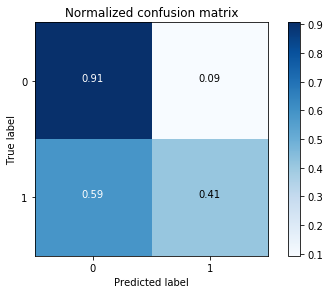

In [18]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test_log)
print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()


In [19]:
coef_dict = {}
for coef, feat in zip(model_log.coef_[0,:],X.columns):
    coef_dict[feat] = coef

In [20]:
coef_dict

{'series': 0.2939737755039147,
 'rating': 0.3751449085575224,
 'top_authors': 1.134423314186235,
 'publish_month_August': 0.3854916079894638,
 'publish_month_December': 0.873210487857992,
 'publish_month_February': -0.46948879893487916,
 'publish_month_January': -0.461355372314164,
 'publish_month_July': -0.44287988667104977,
 'publish_month_June': -0.2323091112629918,
 'publish_month_March': -0.1279945097017843,
 'publish_month_May': -0.41332856391015843,
 'publish_month_November': 0.8114484900391555,
 'publish_month_October': 0.2411543795711555,
 'publish_month_September': 0.40082456295400387,
 'publish_company_Hachette': 0.63030025116537,
 'publish_company_Harper Collins': 0.3296666966795924,
 'publish_company_Houghton Mifflin Harcourt': -0.04491670754100509,
 'publish_company_Macmillan': -0.05451576845082816,
 'publish_company_Penguin Random House': 0.6384502710470911,
 'publish_company_Simon & Schuster': -0.3164066791335785,
 'genre_biography': 0.8229101579515187,
 'genre_children

In [21]:
sorted(coef_dict.items(), key=lambda x: x[1])

[('genre_horror', -1.8673625715863365),
 ('genre_science-fiction', -1.673532036456631),
 ('genre_fantasy', -1.6310110820100625),
 ('genre_historical', -1.480656962352404),
 ('genre_short-stories', -1.32445590237061),
 ('genre_fiction', -1.3153493059920809),
 ('genre_young-adult', -1.2224964991575376),
 ('genre_romance', -1.1322781108609705),
 ('genre_mystery', -0.7695251168871549),
 ('genre_poetry', -0.5279749692143845),
 ('publish_month_February', -0.46948879893487916),
 ('publish_month_January', -0.461355372314164),
 ('publish_month_July', -0.44287988667104977),
 ('publish_month_May', -0.41332856391015843),
 ('publish_company_Simon & Schuster', -0.3164066791335785),
 ('genre_thriller', -0.3115539342697388),
 ('publish_month_June', -0.2323091112629918),
 ('genre_non-fiction', -0.13446173023620323),
 ('publish_month_March', -0.1279945097017843),
 ('genre_sequential-art', -0.05652035114952549),
 ('publish_company_Macmillan', -0.05451576845082816),
 ('publish_company_Houghton Mifflin Har

In [22]:
model_log.intercept_

array([-0.43964852])

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf_2 = GridSearchCV(LogisticRegression(solver='liblinear'), hyperparameters, cv=5, verbose=0,scoring='accuracy')

In [ ]:
best_model = clf_2.fit(X_train, y_train)

In [ ]:
best_model.best_estimator_

In [ ]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

In [ ]:
logreg_2 = best_model.best_estimator_

In [ ]:
logreg_2.fit(X_train, y_train)

In [ ]:
y_hat2 = logreg_2.predict(X_test)

In [ ]:
print_metrics(y_hat2,y_test)

In [ ]:
coef_dict2 = {}
for coef, feat in zip(logreg_2.coef_[0,:],X.columns):
    coef_dict2[feat] = coef

In [ ]:
sorted(coef_dict2.items(), key=lambda x: x[1])

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_hat2)
print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()


In [ ]:
y_test_score = model_log_2.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_score)

y_train_score = model_log.decision_function(X_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

In [ ]:
plot_AUC_ROC(y_test_score,fpr,tpr)

## Test new data

In [30]:
X.columns

Index(['series', 'rating', 'top_authors', 'publish_month_August',
       'publish_month_December', 'publish_month_February',
       'publish_month_January', 'publish_month_July', 'publish_month_June',
       'publish_month_March', 'publish_month_May', 'publish_month_November',
       'publish_month_October', 'publish_month_September',
       'publish_company_Hachette', 'publish_company_Harper Collins',
       'publish_company_Houghton Mifflin Harcourt',
       'publish_company_Macmillan', 'publish_company_Penguin Random House',
       'publish_company_Simon & Schuster', 'genre_biography',
       'genre_childrens', 'genre_fantasy', 'genre_fiction', 'genre_historical',
       'genre_history', 'genre_horror', 'genre_mystery', 'genre_non-fiction',
       'genre_poetry', 'genre_politics', 'genre_romance',
       'genre_science-fiction', 'genre_sequential-art', 'genre_short-stories',
       'genre_thriller', 'genre_young-adult'],
      dtype='object')

In [33]:
new_book_bestseller = [0,4.36,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
# new_book_not = []

In [35]:
new_book = pd.DataFrame(new_book_bestseller)

In [39]:
new_book.transpose()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.0,4.36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
new_book_not_bestseller = [1,3.87,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]

In [45]:
len(new_book_not_bestseller)

37

In [47]:
new_book2 = pd.DataFrame(new_book_not_bestseller)

In [48]:
model_log.predict(new_book2.transpose())

array([1.])

## Helpers

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion')

In [ ]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [ ]:
def plot_AUC_ROC(y_score,fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()